In [1]:
!pip install transformers

In [2]:
import tensorflow as tf
import numpy as np
from transformers import DistilBertTokenizer, create_optimizer
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, Flatten, Masking
from tensorflow.keras.regularizers import l2

2023-12-12 04:20:49.265402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 04:20:49.401231: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-12 04:20:50.278390: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-12-1

In [3]:
data = pd.read_csv('Notebooks/data/data.csv')

In [4]:
X = data['text']
y = data['isfake']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, stratify=None,  random_state=42)

In [6]:
X_train.shape

(10583,)

## Encodings

In [7]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='tf', max_length=512)

train_encodings = tokenize(X_train.tolist())
test_encodings = tokenize(X_test.tolist())

2023-12-12 04:22:45.644829: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 04:22:46.310922: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20613 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


In [8]:
train= np.array(train_encodings['input_ids'])

In [9]:
train1 = np.expand_dims(train, axis=2)


In [10]:
train1.shape

(10583, 512, 1)

In [11]:
train.shape

(10583, 512)

In [12]:
model_rnn = Sequential([
    Masking(mask_value=0, input_shape=(512,1)),
    SimpleRNN(16), ## THIS IS THE RECURRENT LAYER
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation= 'sigmoid') ## final layer for prediction, hence only one node
])

## compile -- add optim, add loss, add metrics
model_rnn.compile(optimizer = 'rmsprop', loss = ['binary_crossentropy'], metrics = ['accuracy'])

es = EarlyStopping(patience=10, restore_best_weights=True)

history_rnn = model_rnn.fit(train1, y_train, epochs=1000, batch_size=16, validation_split=0.2, callbacks=[es])

Epoch 1/1000


2023-12-12 04:23:02.280346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-12 04:23:02.507670: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x56259be925d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-12 04:23:02.507702: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2023-12-12 04:23:02.515853: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-12 04:23:02.629310: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


530/530 [==============================] - 232s 433ms/step - loss: 0.7099 - accuracy: 0.4967 - val_loss: 0.6926 - val_accuracy: 0.5187
Epoch 2/1000
530/530 [==============================] - 228s 431ms/step - loss: 0.6939 - accuracy: 0.5057 - val_loss: 0.6928 - val_accuracy: 0.5187
Epoch 3/1000
530/530 [==============================] - 219s 414ms/step - loss: 0.6942 - accuracy: 0.4992 - val_loss: 0.6926 - val_accuracy: 0.5187
Epoch 4/1000
530/530 [==============================] - 217s 409ms/step - loss: 0.6931 - accuracy: 0.5122 - val_loss: 0.6927 - val_accuracy: 0.5187
Epoch 5/1000
530/530 [==============================] - 215s 405ms/step - loss: 0.6936 - accuracy: 0.5087 - val_loss: 0.6925 - val_accuracy: 0.5187
Epoch 6/1000
530/530 [==============================] - 216s 407ms/step - loss: 0.6931 - accuracy: 0.5110 - val_loss: 0.6926 - val_accuracy: 0.5187
Epoch 7/1000
530/530 [==============================] - 213s 403ms/step - loss: 0.6931 - accuracy: 0.5094 - val_loss: 0.6925 

In [13]:
test= np.array(test_encodings['input_ids'])
test1 = np.expand_dims(test, axis=2)
loss, accuracy = model_rnn.evaluate(test1, y_test)

37/37 [==============================] - 2s 53ms/step - loss: 0.6926 - accuracy: 0.5162


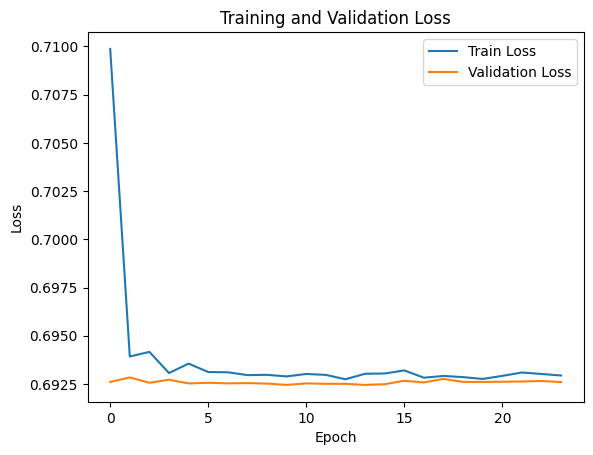

In [14]:
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
model_rnn = Sequential([
    Masking(mask_value=0, input_shape=(512,1)),
    LSTM(300, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    LSTM(300, activation='tanh'), 
    Dense(1, activation= 'sigmoid') ## final layer for prediction, hence only one node
])

## compile -- add optim, add loss, add metrics
model_rnn.compile(optimizer = 'rmsprop', loss = ['binary_crossentropy'], metrics = ['accuracy'])

es = EarlyStopping(patience=5, restore_best_weights=True)

history_rnn = model_rnn.fit(train1, y_train, epochs=1000, batch_size=16, validation_split=0.2, callbacks=[es])

Epoch 1/1000


2023-12-12 05:49:02.928359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8900
2023-12-12 05:49:03.095561: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'


530/530 [==============================] - 30s 42ms/step - loss: 0.7026 - accuracy: 0.5026 - val_loss: 0.6925 - val_accuracy: 0.5187
Epoch 2/1000
530/530 [==============================] - 20s 38ms/step - loss: 0.6953 - accuracy: 0.5022 - val_loss: 0.6929 - val_accuracy: 0.5187
Epoch 3/1000
530/530 [==============================] - 20s 38ms/step - loss: 0.6944 - accuracy: 0.5034 - val_loss: 0.6926 - val_accuracy: 0.5187
Epoch 4/1000
530/530 [==============================] - 20s 38ms/step - loss: 0.6941 - accuracy: 0.5019 - val_loss: 0.6925 - val_accuracy: 0.5187
Epoch 5/1000
530/530 [==============================] - 20s 38ms/step - loss: 0.6936 - accuracy: 0.5066 - val_loss: 0.6925 - val_accuracy: 0.5187
Epoch 6/1000
530/530 [==============================] - 20s 38ms/step - loss: 0.6933 - accuracy: 0.5110 - val_loss: 0.6925 - val_accuracy: 0.5187
Epoch 7/1000
530/530 [==============================] - 20s 38ms/step - loss: 0.6932 - accuracy: 0.5110 - val_loss: 0.6935 - val_accuracy

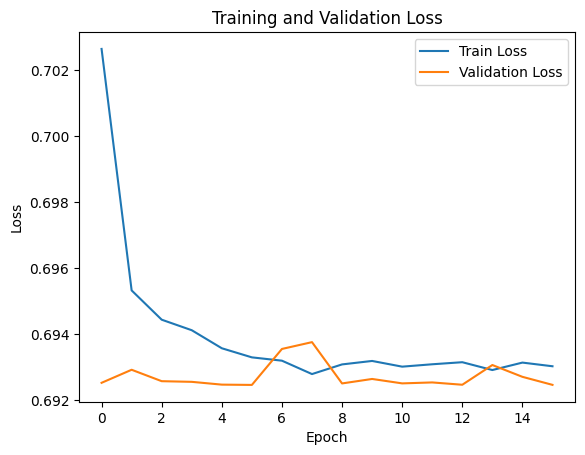

In [16]:
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
model_rnn = Sequential([
    Masking(mask_value=0, input_shape=(512,1)),
    LSTM(15, activation='tanh'),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation= 'sigmoid') ## final layer for prediction, hence only one node
])

## compile -- add optim, add loss, add metrics
model_rnn.compile(optimizer = 'rmsprop', loss = ['binary_crossentropy'], metrics = ['accuracy'])

es = EarlyStopping(patience=5, restore_best_weights=True)

history_rnn = model_rnn.fit(train1, y_train, epochs=1000, batch_size=16, validation_split=0.2, callbacks=[es])

Epoch 1/1000
530/530 [==============================] - 16s 22ms/step - loss: 0.6964 - accuracy: 0.5105 - val_loss: 0.6931 - val_accuracy: 0.5187
Epoch 2/1000
530/530 [==============================] - 10s 19ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6925 - val_accuracy: 0.5187
Epoch 3/1000
530/530 [==============================] - 10s 19ms/step - loss: 0.6933 - accuracy: 0.5063 - val_loss: 0.6926 - val_accuracy: 0.5187
Epoch 4/1000
530/530 [==============================] - 10s 18ms/step - loss: 0.6930 - accuracy: 0.5148 - val_loss: 0.6930 - val_accuracy: 0.5187
Epoch 5/1000
530/530 [==============================] - 10s 19ms/step - loss: 0.6932 - accuracy: 0.5079 - val_loss: 0.6925 - val_accuracy: 0.5187
Epoch 6/1000
530/530 [==============================] - 10s 18ms/step - loss: 0.6929 - accuracy: 0.5102 - val_loss: 0.6925 - val_accuracy: 0.5187
Epoch 7/1000
530/530 [==============================] - 10s 18ms/step - loss: 0.6931 - accuracy: 0.5106 - val_loss: 0.6925 -

In [18]:
model_rnn = Sequential([
    Masking(mask_value=0, input_shape=(512,1)),
    SimpleRNN(300), ## THIS IS THE RECURRENT LAYER
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1, activation= 'sigmoid') ## final layer for prediction, hence only one node
])

## compile -- add optim, add loss, add metrics
model_rnn.compile(optimizer = 'rmsprop', loss = ['binary_crossentropy'], metrics = ['accuracy'])

es = EarlyStopping(patience=5, restore_best_weights=True)

history_rnn = model_rnn.fit(train1, y_train, epochs=1000, batch_size=16, validation_split=0.2, callbacks=[es])

Epoch 1/1000
530/530 [==============================] - 225s 421ms/step - loss: 0.6945 - accuracy: 0.5060 - val_loss: 0.6927 - val_accuracy: 0.5187
Epoch 2/1000
530/530 [==============================] - 223s 421ms/step - loss: 0.6931 - accuracy: 0.5112 - val_loss: 0.6926 - val_accuracy: 0.5187
Epoch 3/1000
530/530 [==============================] - 221s 417ms/step - loss: 0.6929 - accuracy: 0.5120 - val_loss: 0.6926 - val_accuracy: 0.5187
Epoch 4/1000
530/530 [==============================] - 217s 409ms/step - loss: 0.6929 - accuracy: 0.5120 - val_loss: 0.6925 - val_accuracy: 0.5187
Epoch 5/1000
530/530 [==============================] - 216s 408ms/step - loss: 0.6929 - accuracy: 0.5120 - val_loss: 0.6925 - val_accuracy: 0.5187
Epoch 6/1000
530/530 [==============================] - 217s 410ms/step - loss: 0.6929 - accuracy: 0.5120 - val_loss: 0.6925 - val_accuracy: 0.5187
Epoch 7/1000
530/530 [==============================] - 216s 408ms/step - loss: 0.6929 - accuracy: 0.5120 - val_

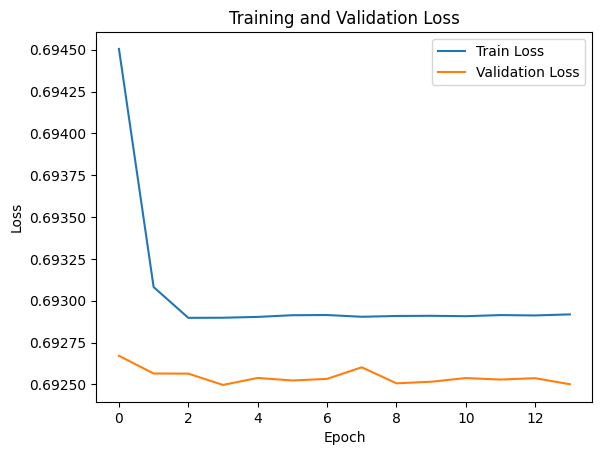

In [19]:
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Xin = tokenize(X_train.tolist())
Xst= tokenize(X_test.tolist())

Xin

{'input_ids': <tf.Tensor: shape=(10583, 512), dtype=int32, numpy=
array([[    0, 14656,   218, ...,     1,     1,     1],
       [    0, 22098,   364, ...,  3860, 18229,     2],
       [    0,  6462,   393, ...,  3826,  1809,     2],
       ...,
       [    0, 18346,  5282, ...,     1,     1,     1],
       [    0,   687, 22437, ...,  1138,  3438,     2],
       [    0,  9502,   237, ...,  2203,   101,     2]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(10583, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}

In [21]:
Xn= np.array(Xin['input_ids'])
Xn = np.expand_dims(Xn, axis=2)
Xn.shape

(10583, 512, 1)

In [ ]:
model_rnn = Sequential([
    Masking(mask_value=0, input_shape=(512,1)),
    SimpleRNN(16), ## THIS IS THE RECURRENT LAYER
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation= 'sigmoid') ## final layer for prediction, hence only one node
])

## compile -- add optim, add loss, add metrics
model_rnn.compile(optimizer = 'rmsprop', loss = ['binary_crossentropy'], metrics = ['accuracy'])

es = EarlyStopping(patience=5, restore_best_weights=True)

history_rnn = model_rnn.fit(Xn, y_train, epochs=1000, batch_size=16, validation_split=0.2, callbacks=[es])

Epoch 1/1000
530/530 [==============================] - 221s 415ms/step - loss: 0.6921 - accuracy: 0.5471 - val_loss: 0.6733 - val_accuracy: 0.6004
Epoch 2/1000
530/530 [==============================] - 219s 413ms/step - loss: 0.6811 - accuracy: 0.5802 - val_loss: 0.6725 - val_accuracy: 0.6009
Epoch 3/1000
530/530 [==============================] - 219s 413ms/step - loss: 0.6826 - accuracy: 0.5826 - val_loss: 0.6743 - val_accuracy: 0.6013
Epoch 4/1000
530/530 [==============================] - 215s 406ms/step - loss: 0.6821 - accuracy: 0.5768 - val_loss: 0.6730 - val_accuracy: 0.5999
Epoch 5/1000
530/530 [==============================] - 215s 406ms/step - loss: 0.6815 - accuracy: 0.5736 - val_loss: 0.6796 - val_accuracy: 0.5980
Epoch 6/1000
530/530 [==============================] - 216s 407ms/step - loss: 0.6787 - accuracy: 0.5822 - val_loss: 0.6805 - val_accuracy: 0.6018
Epoch 7/1000
530/530 [==============================] - 216s 407ms/step - loss: 0.6811 - accuracy: 0.5770 - val_

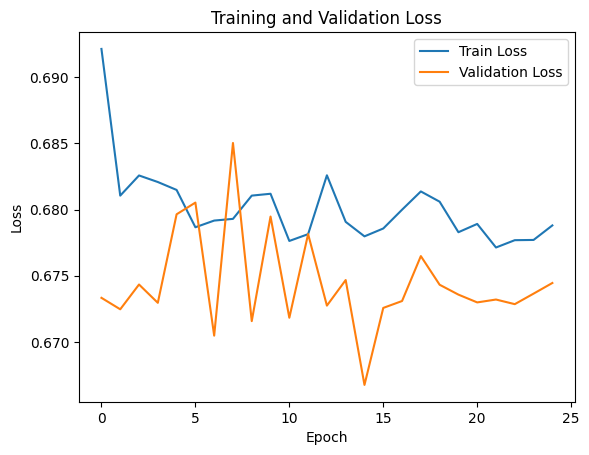

In [ ]:
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_rnn = Sequential([
    Masking(mask_value=0, input_shape=(512,1)),
    LSTM(300, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    LSTM(300, activation='tanh'), 
    Dense(1, activation= 'sigmoid') ## final layer for prediction, hence only one node
])

## compile -- add optim, add loss, add metrics
model_rnn.compile(optimizer = 'rmsprop', loss = ['binary_crossentropy'], metrics = ['accuracy'])

es = EarlyStopping(patience=5, restore_best_weights=True)

history_rnn = model_rnn.fit(Xn, y_train, epochs=1000, batch_size=16, validation_split=0.2, callbacks=[es])

Epoch 1/1000
530/530 [==============================] - 925s 2s/step - loss: 0.5290 - accuracy: 0.7260 - val_loss: 0.6108 - val_accuracy: 0.7161
Epoch 2/1000
530/530 [==============================] - 912s 2s/step - loss: 0.4493 - accuracy: 0.7909 - val_loss: 0.4957 - val_accuracy: 0.7884
Epoch 3/1000
530/530 [==============================] - 917s 2s/step - loss: 0.4310 - accuracy: 0.7971 - val_loss: 0.4356 - val_accuracy: 0.7955
Epoch 4/1000
530/530 [==============================] - 926s 2s/step - loss: 0.4311 - accuracy: 0.7948 - val_loss: 0.4311 - val_accuracy: 0.7974
Epoch 5/1000
530/530 [==============================] - 913s 2s/step - loss: 0.4330 - accuracy: 0.7962 - val_loss: 0.4330 - val_accuracy: 0.7964
Epoch 6/1000
530/530 [==============================] - 913s 2s/step - loss: 0.4328 - accuracy: 0.7965 - val_loss: 0.4231 - val_accuracy: 0.7969
Epoch 7/1000
530/530 [==============================] - 912s 2s/step - loss: 0.4250 - accuracy: 0.7981 - val_loss: 0.4255 - val_ac

In [ ]:
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_rnn = Sequential([
    Masking(mask_value=0, input_shape=(512,1)),
    LSTM(300, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    LSTM(300, activation='tanh'), 
    Dense(1, activation= 'sigmoid') ## final layer for prediction, hence only one node
])

## compile -- add optim, add loss, add metrics
model_rnn.compile(optimizer = 'rmsprop', loss = ['binary_crossentropy'], metrics = ['accuracy'])

es = EarlyStopping(patience=5, restore_best_weights=True)

history_rnn = model_rnn.fit(Xn, y_train, epochs=1000, batch_size=16, validation_split=0.2, callbacks=[es])

In [ ]:
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()